In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.tools as pt

import sklearn
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.cluster import KMeans
from sklearn.metrics import median_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense


Using TensorFlow backend.


In [2]:
df = pd.read_csv("hhblock_dataset/block_0.csv")
df.head()

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000002,13-10-2012,0.263,0.269,0.275,0.256,0.211,0.136,0.161,0.119,...,0.918,0.278,0.267,0.239,0.230,0.233,0.235,0.188,0.259,0.250
1,MAC000002,14-10-2012,0.262,0.166,0.226,0.088,0.126,0.082,0.123,0.083,...,1.075,0.956,0.821,0.745,0.712,0.511,0.231,0.210,0.278,0.159
2,MAC000002,15-10-2012,0.192,0.097,0.141,0.083,0.132,0.070,0.130,0.074,...,1.164,0.249,0.225,0.258,0.260,0.334,0.299,0.236,0.241,0.237
3,MAC000002,16-10-2012,0.237,0.237,0.193,0.118,0.098,0.107,0.094,0.109,...,0.966,0.172,0.192,0.228,0.203,0.211,0.188,0.213,0.157,0.202
4,MAC000002,17-10-2012,0.157,0.211,0.155,0.169,0.101,0.117,0.084,0.118,...,0.223,0.075,0.230,0.208,0.265,0.377,0.327,0.277,0.288,0.256


In [3]:
# List of unique households in block 0
df['LCLid'].unique()

array(['MAC000002', 'MAC000246', 'MAC000450', 'MAC001074', 'MAC003223',
       'MAC003239', 'MAC003252', 'MAC003281', 'MAC003305', 'MAC003348',
       'MAC003388', 'MAC003394', 'MAC003400', 'MAC003422', 'MAC003423',
       'MAC003428', 'MAC003449', 'MAC003463', 'MAC003482', 'MAC003553',
       'MAC003557', 'MAC003566', 'MAC003579', 'MAC003597', 'MAC003613',
       'MAC003646', 'MAC003656', 'MAC003668', 'MAC003680', 'MAC003686',
       'MAC003718', 'MAC003719', 'MAC003737', 'MAC003740', 'MAC003775',
       'MAC003805', 'MAC003817', 'MAC003826', 'MAC003844', 'MAC003851',
       'MAC003856', 'MAC003863', 'MAC003874', 'MAC004034', 'MAC004179',
       'MAC004247', 'MAC004319', 'MAC004387', 'MAC004431', 'MAC005492'],
      dtype=object)

In [4]:
# Number of records for each household in block 0
df.pivot_table(index=['LCLid'], aggfunc='size')

LCLid
MAC000002    498
MAC000246    814
MAC000450    410
MAC001074    222
MAC003223    526
MAC003239    526
MAC003252    513
MAC003281    519
MAC003305    519
MAC003348    440
MAC003388    516
MAC003394    510
MAC003400    511
MAC003422    494
MAC003423    503
MAC003428    508
MAC003449    507
MAC003463    311
MAC003482    509
MAC003553    503
MAC003557    405
MAC003566    503
MAC003579    505
MAC003597    501
MAC003613    500
MAC003646    502
MAC003656    500
MAC003668    499
MAC003680    493
MAC003686    497
MAC003718    361
MAC003719    497
MAC003737    496
MAC003740    495
MAC003775    448
MAC003805    492
MAC003817    493
MAC003826    491
MAC003844    488
MAC003851    489
MAC003856    484
MAC003863    487
MAC003874    487
MAC004034    435
MAC004179    646
MAC004247    637
MAC004319    642
MAC004387    708
MAC004431    697
MAC005492    549
dtype: int64

In [5]:
# Household with maximum records is used for further analysis
df_hh = df[df['LCLid'] == 'MAC000246']
df_hh.head()

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
498,MAC000246,04-12-2011,0.175,0.098,0.144,0.065,0.071,0.037,0.047,0.042,...,0.134,0.314,0.822,0.226,0.190,1.054,1.116,0.936,0.478,0.375
499,MAC000246,05-12-2011,0.471,0.934,0.326,0.143,0.130,0.109,0.123,0.088,...,0.036,0.127,0.074,0.060,0.054,0.050,0.066,0.079,0.164,0.347
500,MAC000246,06-12-2011,0.303,1.216,0.914,0.467,0.660,0.705,0.154,0.108,...,0.048,0.062,0.057,0.101,0.597,0.344,1.042,0.948,0.523,0.986
501,MAC000246,07-12-2011,0.735,0.189,0.410,0.862,0.432,0.056,0.077,0.030,...,0.073,0.136,0.105,0.101,0.072,0.072,0.092,0.228,0.321,0.873
502,MAC000246,08-12-2011,0.910,0.513,0.490,0.841,0.473,0.058,0.037,0.052,...,0.065,0.066,0.128,0.419,0.681,0.811,1.657,1.230,0.751,1.049


In [6]:
# df_new = pd.DataFrame()
df_hh['total_consumption'] = df_hh.sum(axis=1)

/Users/safdharalishaik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
# Extract year and month from date
df_hh['year'] = pd.DatetimeIndex(df_hh['day']).year
df_hh['month'] = pd.DatetimeIndex(df_hh['day']).month
df_hh['date'] = pd.DatetimeIndex(df_hh['day']).day

/Users/safdharalishaik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/safdharalishaik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/safdharalishaik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [8]:
df_hh = df_hh.reset_index()

In [9]:
df_hh = df_hh[['day', 'total_consumption','year','month','date']]

In [10]:
df_hh.head()
df_hh.dtypes
df_hh.info()
df_hh.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   day                814 non-null    object 
 1   total_consumption  814 non-null    float64
 2   year               814 non-null    int64  
 3   month              814 non-null    int64  
 4   date               814 non-null    int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 31.9+ KB


,total_consumption,year,month,date
count,814.000000,814.000000,814.000000,814.000000
mean,16.834709,2012.554054,6.445946,15.631450
std,6.970511,0.677454,3.592928,8.912409
min,3.571000,2011.000000,1.000000,1.000000
25%,11.271000,2012.000000,3.000000,8.000000
50%,16.491000,2013.000000,6.000000,16.000000
75%,21.097500,2013.000000,10.000000,23.000000
max,47.168000,2014.000000,12.000000,31.000000


In [11]:
from  scipy.stats import skew, kurtosis, shapiro

mean = np.mean(df_hh.total_consumption.values)
std = np.std(df_hh.total_consumption.values)
skew = skew(df_hh.total_consumption.values)
ex_kurt = kurtosis(df_hh.total_consumption)
print("Skewness: {} \nKurtosis: {}".format(skew, ex_kurt+3))

Skewness: 0.5757792208459902 
Kurtosis: 3.3603468268671506


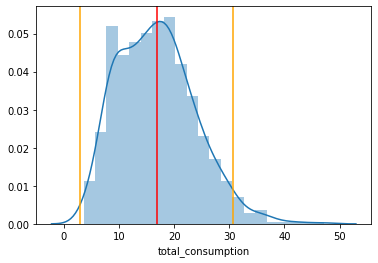

In [12]:
# Data Visualization
# Target Analysis - Normality

sns.distplot(df_hh['total_consumption'])

plt.axvline(x=mean, color='r', linestyle='-', label="\mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')

# The plot almost normal distribution

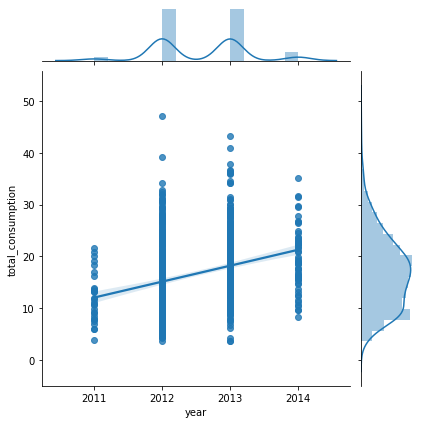

In [13]:
sns.jointplot(x=df_hh["year"],
              y=df_hh["total_consumption"],
              data=df_hh,
             kind="reg")

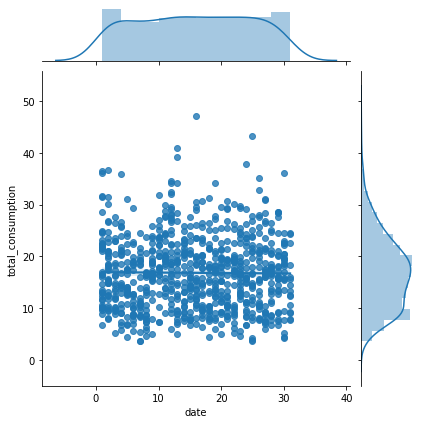

In [14]:
sns.jointplot(x=df_hh["date"],
              y=df_hh["total_consumption"],
              data=df_hh,
             kind="reg")

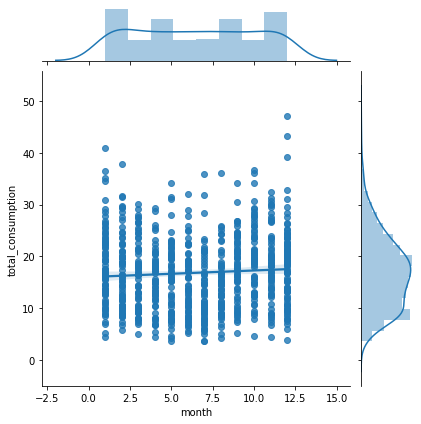

In [15]:
sns.jointplot(x=df_hh["month"],
              y=df_hh["total_consumption"],
              data=df_hh,
             kind="reg")

In [16]:
weather = pd.read_csv('weather_daily_darksky.csv')
weather.head(4)

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25


In [17]:
def changeDateFormat(date): 
    date = dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S').strftime('%d-%m-%Y')
    return(date)

dtx = []
for t in weather['time']:
    dtx.append(changeDateFormat(t))
    
weather['date'] = pd.DataFrame(dtx)
weather.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,date
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52,11-11-2011
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53,11-12-2011
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10,27-12-2011
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25,02-12-2011
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,...,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99,24-12-2011


In [18]:
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','date']]
weather = weather.dropna()
weather.head()

,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,date
0,11.96,123,9.40,0.79,3.88,1016.08,10.87,3.30,0.95,10.87,11.96,1.0,10.87,8.85,10.87,6.48,0.52,11-11-2011
1,8.59,198,4.49,0.56,3.94,1007.71,5.62,12.09,0.88,-0.64,5.72,1.0,3.09,2.48,8.59,0.11,0.53,11-12-2011
2,10.33,225,5.47,0.85,3.54,1032.76,10.33,13.39,0.74,5.52,10.33,0.0,8.03,8.03,10.33,5.59,0.10,27-12-2011
3,8.07,232,3.69,0.32,3.00,1012.12,5.33,11.89,0.87,3.26,5.33,1.0,6.33,2.56,7.36,0.46,0.25,02-12-2011
4,8.22,252,2.79,0.37,4.46,1028.17,5.02,13.16,0.80,4.37,5.32,1.0,7.45,3.17,7.93,-0.51,0.99,24-12-2011


In [19]:
weather_energy =  df_hh.merge(weather,left_on='day',right_on='date')
weather_energy.head()

,day,total_consumption,year,month,date_x,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,...,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,date_y
0,04-12-2011,20.763,2011,4,12,9.11,254,4.87,0.36,4.31,...,0.82,-1.69,6.66,1.0,2.81,4.69,9.11,1.03,0.31,04-12-2011
1,05-12-2011,6.020,2011,5,12,6.87,254,0.84,0.20,5.57,...,0.77,-1.61,3.13,1.0,2.68,2.81,6.87,-1.69,0.34,05-12-2011
2,06-12-2011,13.322,2011,6,12,6.91,245,2.15,0.34,4.79,...,0.83,1.90,3.77,1.0,5.16,2.68,6.91,-1.61,0.37,06-12-2011
3,07-12-2011,9.062,2011,7,12,9.02,263,1.79,0.29,7.06,...,0.68,0.63,5.14,1.0,4.27,4.91,9.02,0.94,0.40,07-12-2011
4,08-12-2011,13.664,2011,8,12,12.89,234,5.96,0.53,7.01,...,0.81,-0.37,12.89,1.0,3.76,4.27,12.89,0.63,0.43,08-12-2011


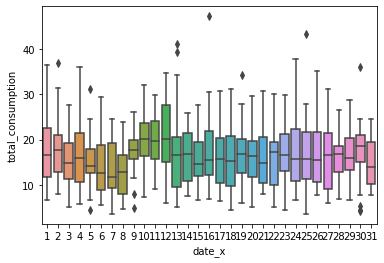

In [20]:
sns.boxplot(x="date_x", y="total_consumption", data=weather_energy)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


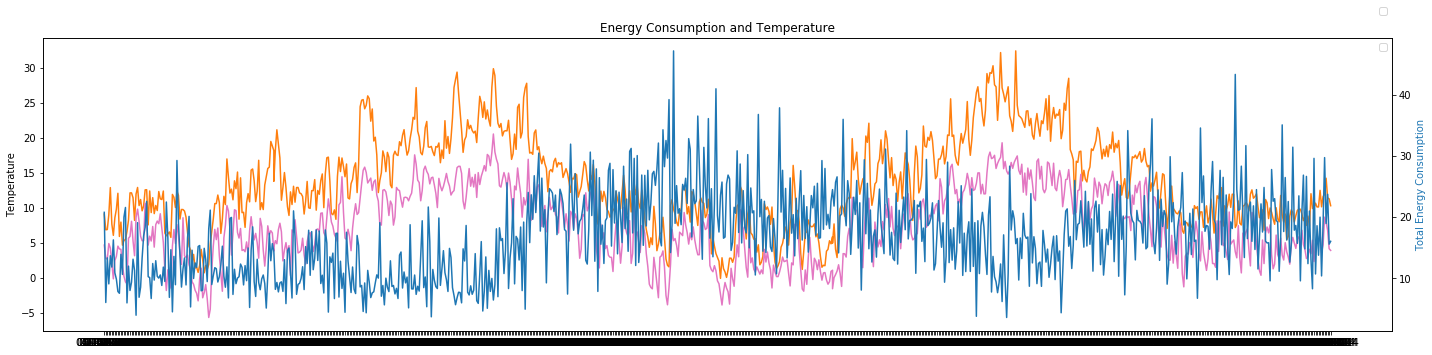

In [21]:
# Temperature

## As expected, there is an inverse relationship between temperature and electricity consumption.
## This is perfectly aligned to the logical and business assumption that when the temperature is low,
## the electricity consumption is high due to increase in use of heaters.

fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:orange')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:pink')
ax1.set_ylabel('Temperature')
ax1.legend()
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.total_consumption,color = 'tab:blue')
ax2.set_ylabel('Total Energy Consumption',color = 'tab:blue')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

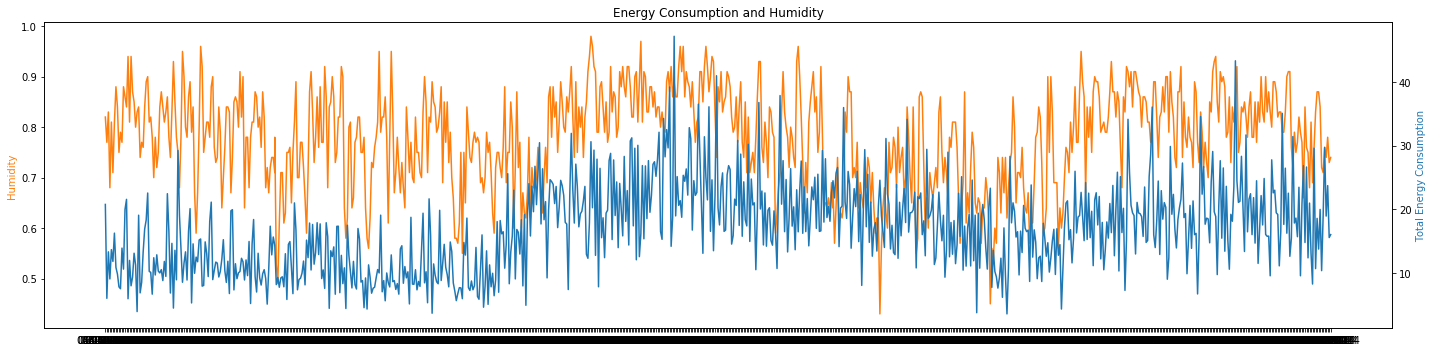

In [22]:
# Humidity

## From the chart it is clear that humidity and electricity consumption are following the same trend

fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:orange')
ax1.set_ylabel('Humidity',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.total_consumption,color = 'tab:blue')
ax2.set_ylabel('Total Energy Consumption',color = 'tab:blue')
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

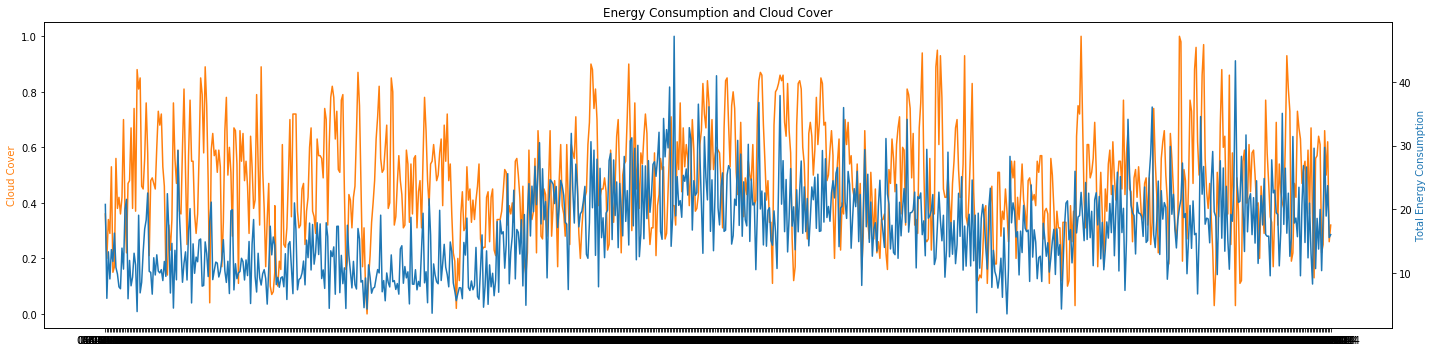

In [23]:
# Cloud Cover

## Cloud cover shows similar trends as the electricity consumption

fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:orange')
ax1.set_ylabel('Cloud Cover',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.total_consumption,color = 'tab:blue')
ax2.set_ylabel('Total Energy Consumption',color = 'tab:blue')
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

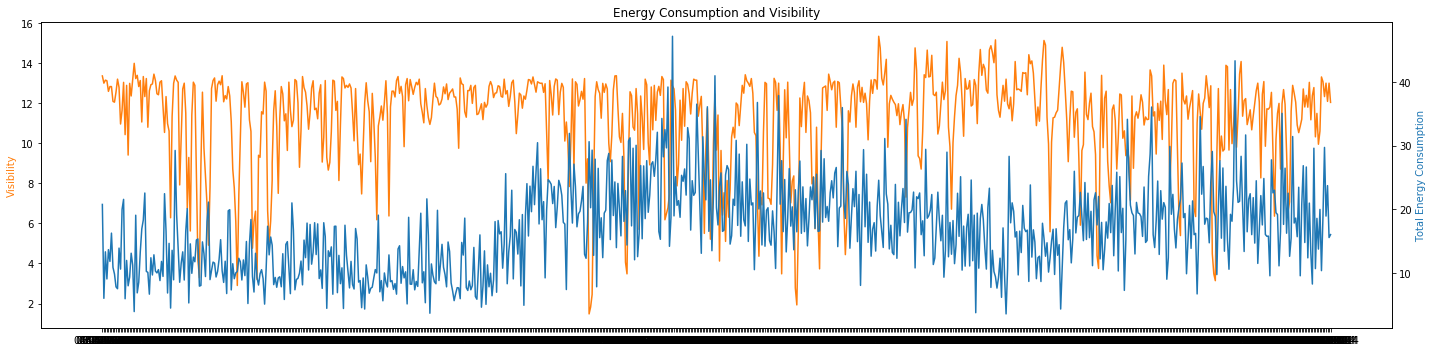

In [24]:
# Visibility

## The visibility should not affect the energy consumption as it is more linkely to affect outdoor activies or factors.
## The graph displays the same. 

fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.visibility, color = 'tab:orange')
ax1.set_ylabel('Visibility',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.total_consumption,color = 'tab:blue')
ax2.set_ylabel('Total Energy Consumption',color = 'tab:blue')
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.show()

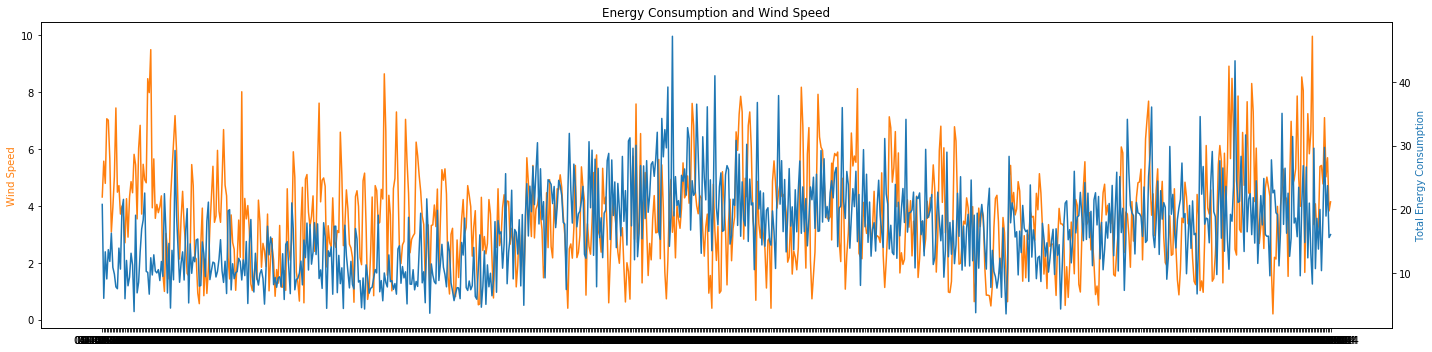

In [25]:
# Wind Speed

## Wind is a factor more likely to affect the outdoor activites and factor.
## The graph supports the logical assumption.

fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color = 'tab:orange')
ax1.set_ylabel('Wind Speed',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.total_consumption,color = 'tab:blue')
ax2.set_ylabel('Total Energy Consumption',color = 'tab:blue')
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

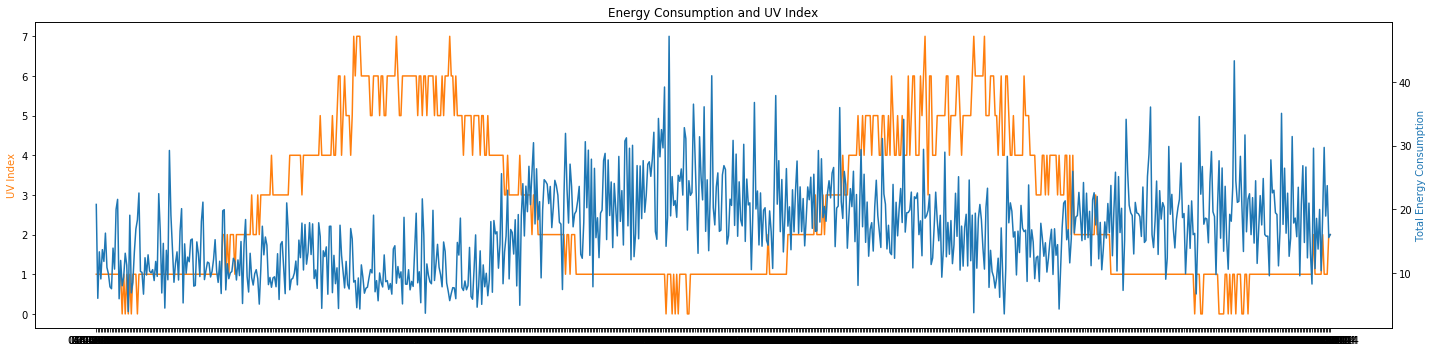

In [26]:
# UV index

## The UV index has an inverse relationship with the electricity consumption. Reason, not sure.

fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:orange')
ax1.set_ylabel('UV Index',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.total_consumption,color = 'tab:blue')
ax2.set_ylabel('Total Energy Consumption',color = 'tab:blue')
plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.show()

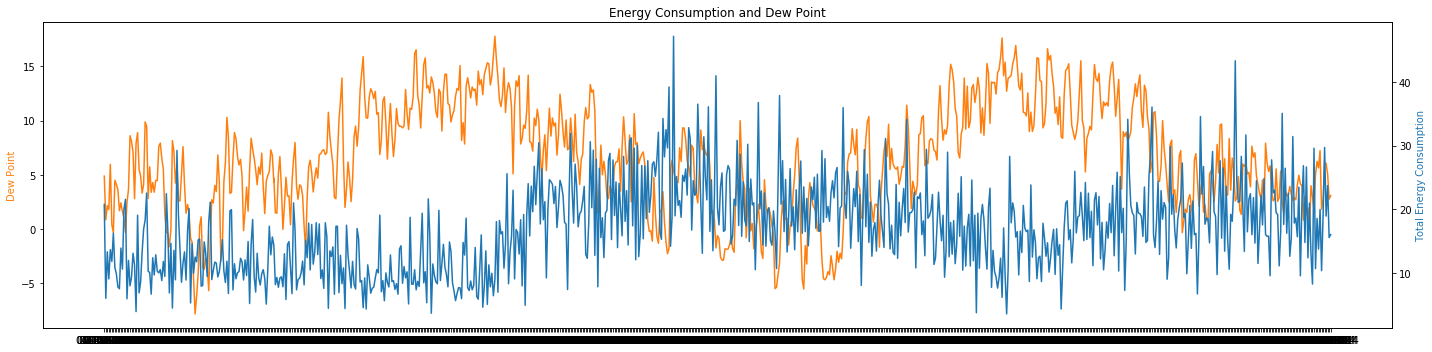

In [27]:
# dewPoint

## Dew point is a function of humidity and temperature. Hence, it is seems to have similar relationship with energy consumption.
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color = 'tab:orange')
ax1.set_ylabel('Dew Point',color = 'tab:orange')
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.total_consumption,color = 'tab:blue')
ax2.set_ylabel('Total Energy Consumption',color = 'tab:blue')
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()

In [28]:
cor_matrix = weather_energy[['total_consumption','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()
cor_matrix

,total_consumption,temperatureMax,dewPoint,cloudCover,windSpeed,pressure,visibility,humidity,uvIndex,moonPhase
total_consumption,1.000000,-0.303946,-0.235534,0.110579,0.044402,-0.172359,-0.089911,0.207233,-0.351517,0.010705
temperatureMax,-0.303946,1.000000,0.866259,-0.335271,-0.156736,0.119205,0.259983,-0.403573,0.697341,0.002861
dewPoint,-0.235534,0.866259,1.000000,-0.026619,-0.093161,-0.028692,0.044333,0.055309,0.490518,-0.007366
cloudCover,0.110579,-0.335271,-0.026619,1.000000,0.174046,-0.095108,-0.331544,0.484469,-0.250902,-0.062872
windSpeed,0.044402,-0.156736,-0.093161,0.174046,1.000000,-0.352014,0.275724,-0.035624,-0.153837,-0.016112
pressure,-0.172359,0.119205,-0.028692,-0.095108,-0.352014,1.000000,-0.013162,-0.256767,0.104752,0.041920
visibility,-0.089911,0.259983,0.044333,-0.331544,0.275724,-0.013162,1.000000,-0.578811,0.243784,0.072198
humidity,0.207233,-0.403573,0.055309,0.484469,-0.035624,-0.256767,-0.578811,1.000000,-0.530536,-0.012364
uvIndex,-0.351517,0.697341,0.490518,-0.250902,-0.153837,0.104752,0.243784,-0.530536,1.000000,0.002739
moonPhase,0.010705,0.002861,-0.007366,-0.062872,-0.016112,0.041920,0.072198,-0.012364,0.002739,1.000000


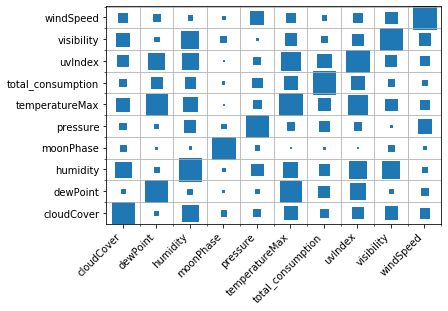

In [29]:
def heatmap(x, y, size):
    fig, ax = plt.subplots()
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s' # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

corr = pd.melt(cor_matrix.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

In [30]:
#scaling
scaler = MinMaxScaler()
weather_scaled = scaler.fit_transform(weather_energy[['temperatureMax','humidity','windSpeed']])
weather_scaled

array([[0.28250154, 0.70909091, 0.42110656],
       [0.21349353, 0.61818182, 0.55020492],
       [0.21472582, 0.72727273, 0.47028689],
       ...,
       [0.35397412, 0.63636364, 0.5625    ],
       [0.34966112, 0.54545455, 0.37090164],
       [0.31947012, 0.56363636, 0.40368852]])

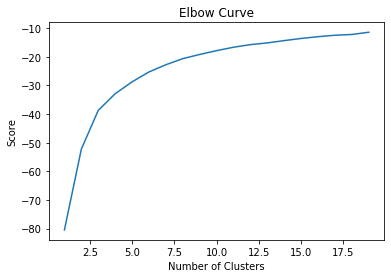

In [31]:
# optimum K
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(weather_scaled).score(weather_scaled) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [32]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(weather_scaled)
weather_energy['weather_cluster'] = kmeans.labels_

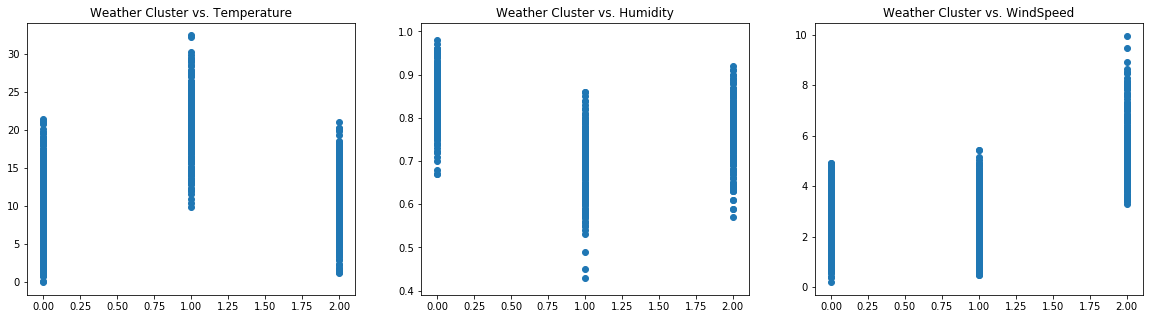

In [33]:
# Cluster Relationships with weather variables
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)

plt.scatter(weather_energy.weather_cluster,weather_energy.temperatureMax)
plt.title('Weather Cluster vs. Temperature')
plt.subplot(1, 3, 2)

plt.scatter(weather_energy.weather_cluster,weather_energy.humidity)
plt.title('Weather Cluster vs. Humidity')
plt.subplot(1, 3, 3)

plt.scatter(weather_energy.weather_cluster,weather_energy.windSpeed)
plt.title('Weather Cluster vs. WindSpeed')

plt.show()

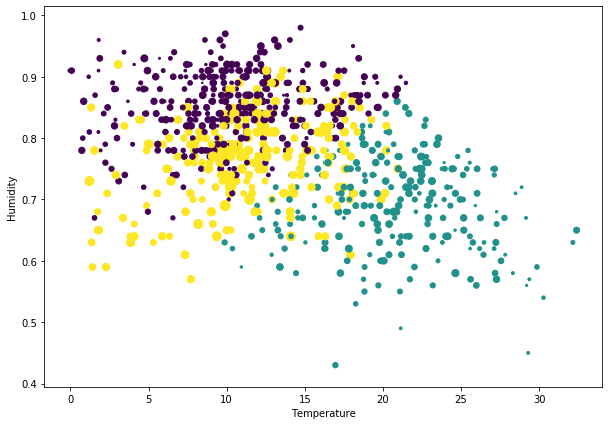

In [34]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.scatter(weather_energy.temperatureMax, 
            weather_energy.humidity,
            s = weather_energy.windSpeed*10,
            c = weather_energy.weather_cluster)
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Humidity')
plt.show()

In [35]:
holiday = pd.read_csv('uk_bank_holidays.csv')

dtx = []
for t in holiday['Bank holidays']:
    dtx.append(dt.datetime.strptime(t, '%Y-%m-%d').strftime('%d-%m-%Y'))
        
holiday['Bank holidays'] = pd.DataFrame(dtx)
holiday.head()

,Bank holidays,Type
0,26-12-2012,Boxing Day
1,25-12-2012,Christmas Day
2,27-08-2012,Summer bank holiday
3,06-05-2012,Queen?s Diamond Jubilee (extra bank holiday)
4,06-04-2012,Spring bank holiday (substitute day)


In [36]:
weather_energy = weather_energy.merge(holiday, left_on = 'day',right_on = 'Bank holidays',how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

In [37]:
weather_energy.groupby('holiday_ind').count()

,day,total_consumption,year,month,date_x,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,...,uvIndex,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,date_y,weather_cluster,Bank holidays,Type
holiday_ind,,,,,,,,,,,,,,,,,,,,,
0,796,796,796,796,796,796,796,796,796,796,...,796,796,796,796,796,796,796,796,0,0
1,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17


In [38]:
weather_energy.head()

,day,total_consumption,year,month,date_x,temperatureMax,windBearing,dewPoint,cloudCover,windSpeed,...,temperatureLow,temperatureMin,temperatureHigh,apparentTemperatureMin,moonPhase,date_y,weather_cluster,Bank holidays,Type,holiday_ind
0,04-12-2011,20.763,2011,4,12,9.11,254,4.87,0.36,4.31,...,2.81,4.69,9.11,1.03,0.31,04-12-2011,0,NaN,NaN,0
1,05-12-2011,6.020,2011,5,12,6.87,254,0.84,0.20,5.57,...,2.68,2.81,6.87,-1.69,0.34,05-12-2011,2,NaN,NaN,0
2,06-12-2011,13.322,2011,6,12,6.91,245,2.15,0.34,4.79,...,5.16,2.68,6.91,-1.61,0.37,06-12-2011,2,NaN,NaN,0
3,07-12-2011,9.062,2011,7,12,9.02,263,1.79,0.29,7.06,...,4.27,4.91,9.02,0.94,0.40,07-12-2011,2,NaN,NaN,0
4,08-12-2011,13.664,2011,8,12,12.89,234,5.96,0.53,7.01,...,3.76,4.27,12.89,0.63,0.43,08-12-2011,2,NaN,NaN,0


In [39]:
weather_energy.set_index(['day'],inplace=True)

In [40]:
from sklearn.model_selection import train_test_split
# Split the dataset into 80 - 20 as train and test sets
model_data = weather_energy[['total_consumption','weather_cluster','holiday_ind']]

train, test = train_test_split(model_data, test_size = 0.2,shuffle=False)

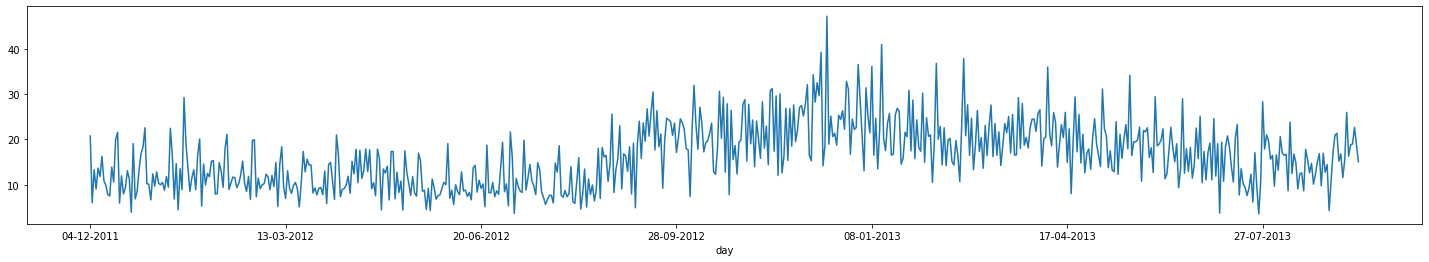

In [41]:
train['total_consumption'].plot(figsize=(25,4))

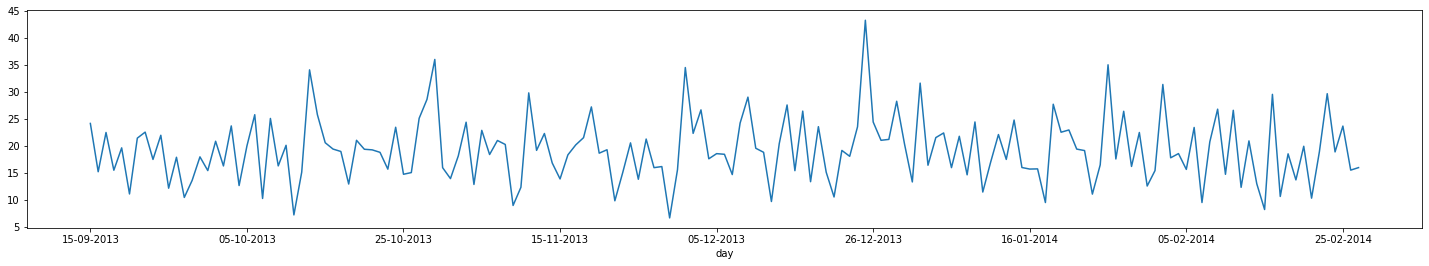

In [42]:
test['total_consumption'].plot(figsize=(25,4))

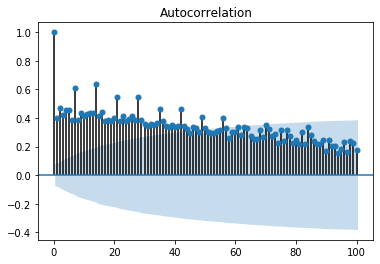

In [43]:
# ACF

## This plot displays a gradual decay 

plot_acf(train.total_consumption,lags=100)
plt.show()

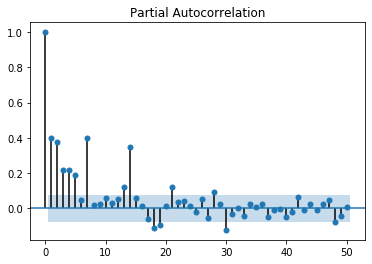

In [44]:
# PACF

## This plot shows sharp drop after the first lag.

plot_pacf(train.total_consumption,lags=50)
plt.show()

In [45]:
# Dickey fuller's test

## Since the p > 0.05 the data is not stationary.

t = sm.tsa.adfuller(train.total_consumption, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -1.601199
p-value                          0.482991
#Lags Used                      20.000000
Number of Observations Used    629.000000
dtype: float64

In [46]:
## To convert non-stationary data to stationary we need to perform differencing

# Function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [47]:
# Differencing function call

## Now the p-value < 0.05

t  = sm.tsa.adfuller(difference(train.total_consumption,20), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                  -5.442368
p-value                          0.000003
#Lags Used                      20.000000
Number of Observations Used    609.000000
dtype: float64

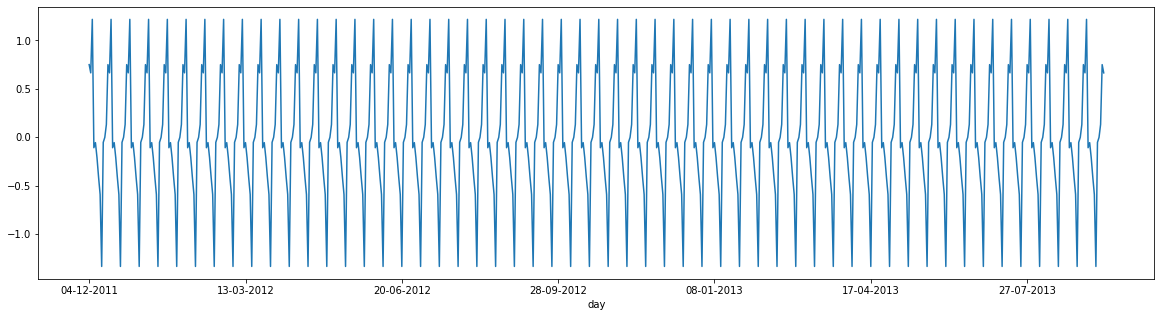

In [48]:
# Seasonal decomposition

s = sm.tsa.seasonal_decompose(train.total_consumption,freq=12)
s.seasonal.plot(figsize=(20,5))

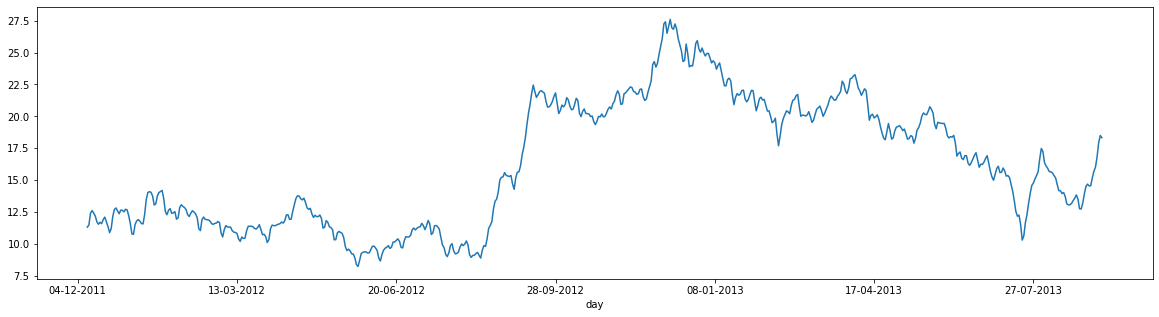

In [49]:
s.trend.plot(figsize=(20,5))

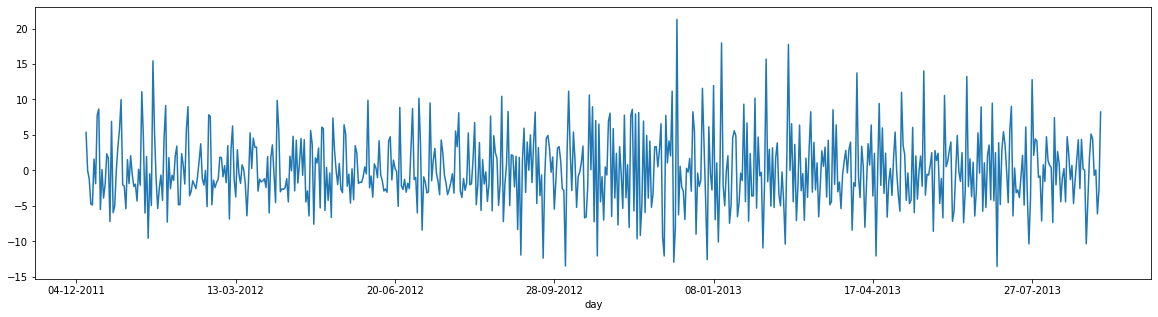

In [50]:
s.resid.plot(figsize=(20,5))

In [51]:
endog = train['total_consumption']
exog = train[['weather_cluster','holiday_ind']]

mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(1,0,1),seasonal_order=(1,1, 0, 12))
model_fit = mod.fit()
model_fit.summary()

/Users/safdharalishaik/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/safdharalishaik/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/Users/safdharalishaik/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/safdharalishaik/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                   total_consumption   No. Observations:                  650
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood               -2117.650
Date:                             Tue, 01 Sep 2020   AIC                           4247.300
Time:                                     15:26:36   BIC                           4274.050
Sample:                                          0   HQIC                          4257.684
                                             - 650                                         
Covariance Type:                               opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
weather_cluster    -0.1186      0.311     -0.381      0.703      -0.728       0.491
holiday_ind         1.6917      1.180      1.434      0.152      -0.620       4.004
ar.L1              -0.4707      0.526     -0.895      0.371      -1.501       0.560
ma.L1               0.4202      0.544      0.772      0.440      -0.647       1.487
ar.S.L12           -0.4581      0.032    -14.161      0.000      -0.521      -0.395
sigma2             44.5266      2.379     18.717      0.000      39.864      49.189
===================================================================================
Ljung-Box (Q):                      472.07   Jarque-Bera (JB):                 2.29
Prob(Q):                              0.00   Prob(JB):                         0.32
Heteroskedasticity (H):               1.57   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

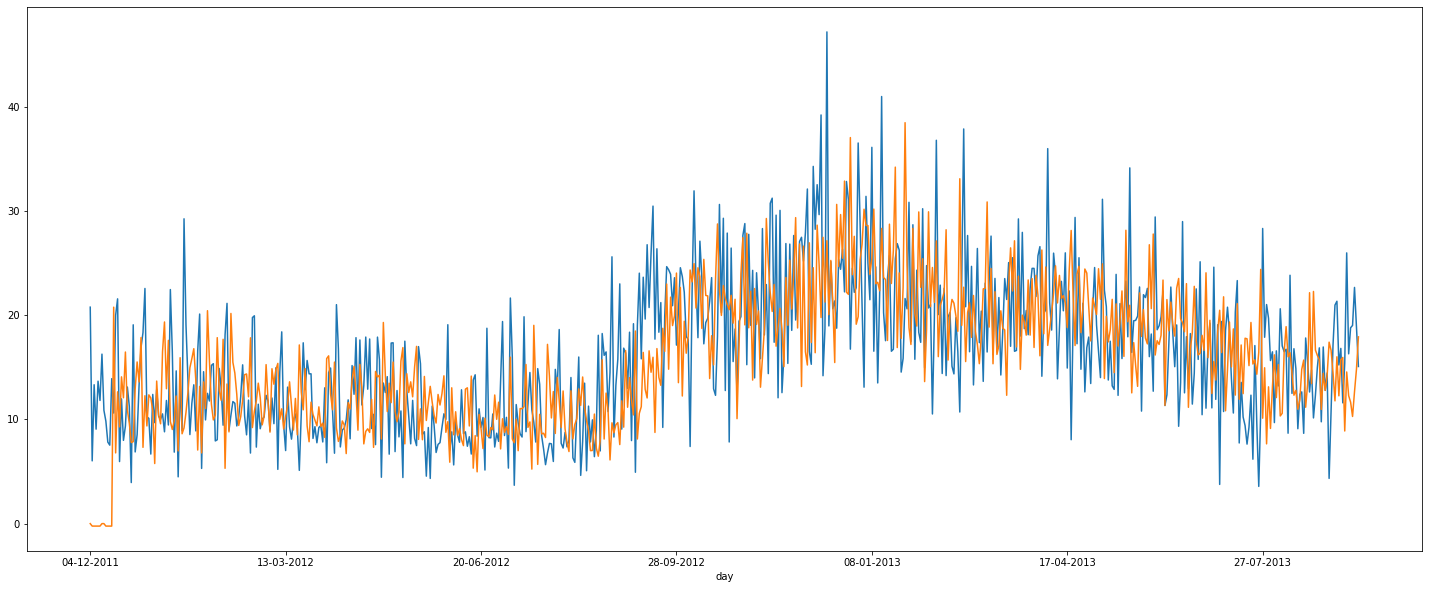

In [52]:
# Model training

train['total_consumption'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

In [53]:
# Prediction

predict = model_fit.predict(start = len(train),end = len(train)+len(test)-1,exog = test[['weather_cluster','holiday_ind']])
test['predicted'] = predict.values
test.tail(5)

/Users/safdharalishaik/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/safdharalishaik/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,total_consumption,weather_cluster,holiday_ind,predicted
day,,,,
23-02-2014,29.716,2,0,16.148863
24-02-2014,18.935,2,0,13.111444
25-02-2014,23.717,2,0,12.900099
26-02-2014,15.562,2,0,22.931991
27-02-2014,16.026,2,0,15.149518


In [54]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_ts(testY,testPredict):
    MAE = median_absolute_error(testY,testPredict) 
    MAPE = mean_absolute_percentage_error(testY,testPredict)
    MSE = mean_squared_error(testY,testPredict)
    RMSE = math.sqrt(MSE)
    return MAE,MAPE,MSE,RMSE


In [55]:
test_pred = test['predicted']
test_tc = test['total_consumption']

evaluate_ts(test_tc,test_pred)

(4.7551605274425945, 28.954037063415395, 51.25067833956153, 7.158957908771467)

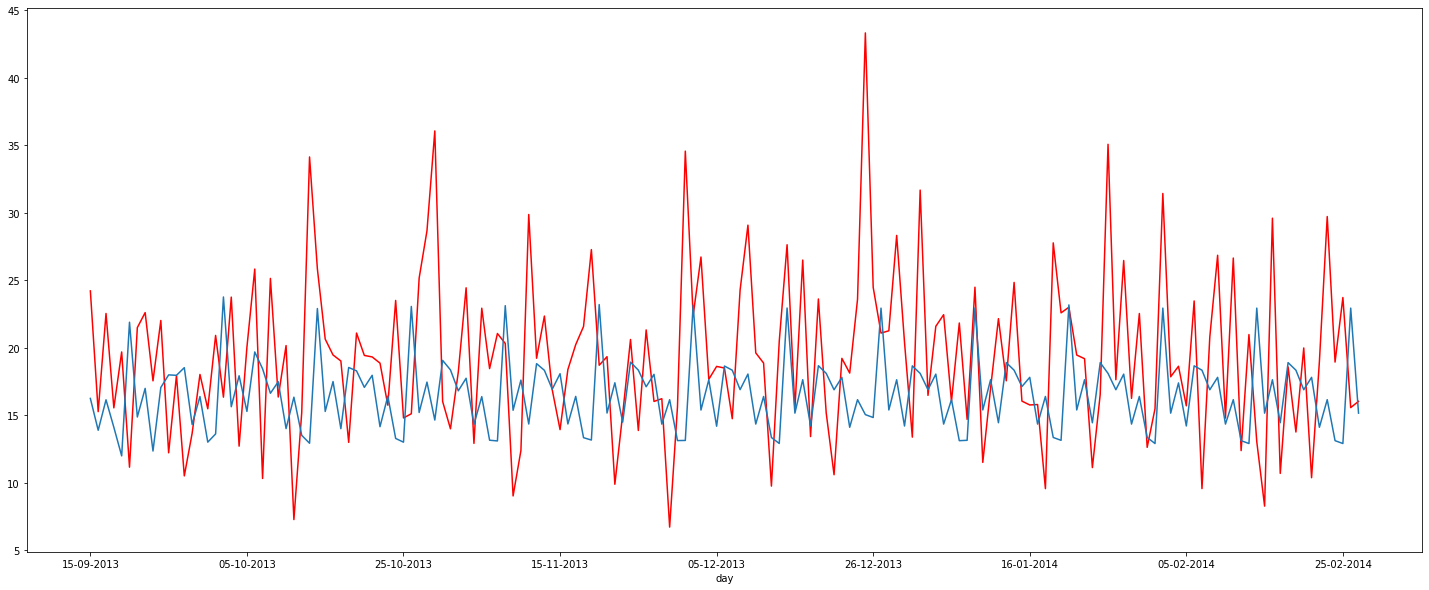

In [56]:
test['total_consumption'].plot(figsize=(25,10),color = 'red')
test['predicted'].plot()
plt.show()

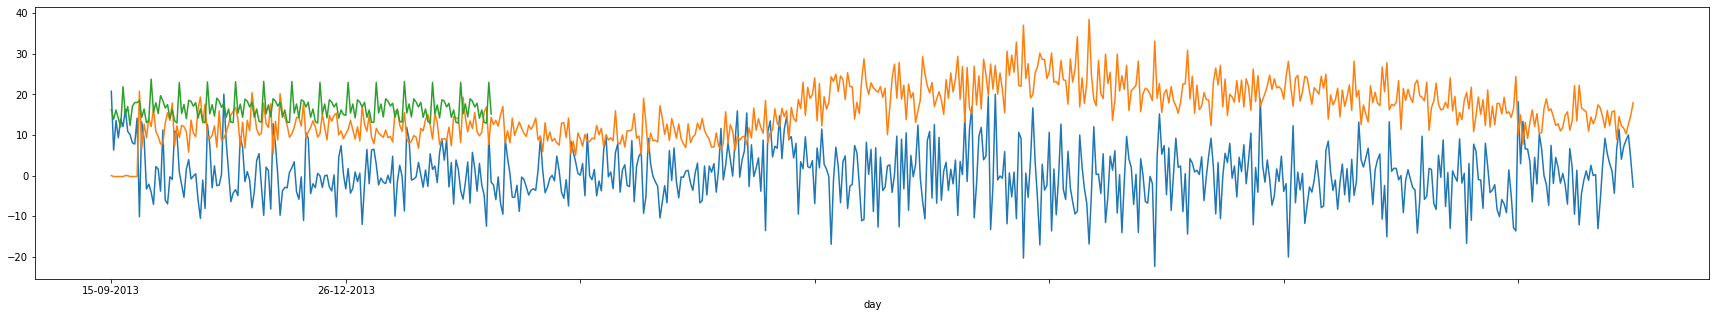

In [57]:
model_fit.resid.plot(figsize= (30,5))
model_fit.fittedvalues.plot(figsize = (30,5))
test.predicted.plot()

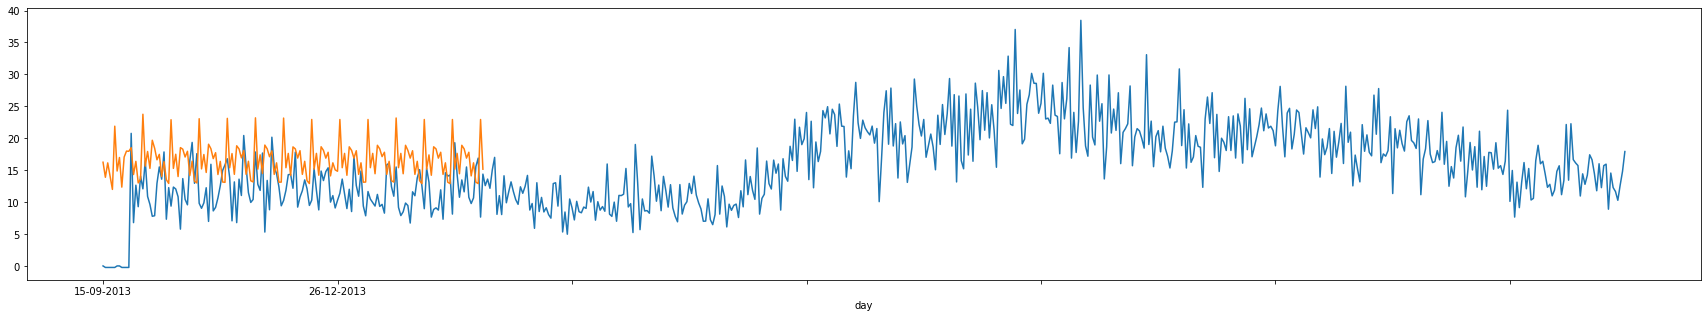

In [58]:
model_fit.fittedvalues.plot(figsize = (30,5))
test.predicted.plot()

In [59]:
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(7).mean()
    rolling_std = ts.rolling(7).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()

In [60]:
# Augmented Dickey–Fuller test
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' ,result[4])

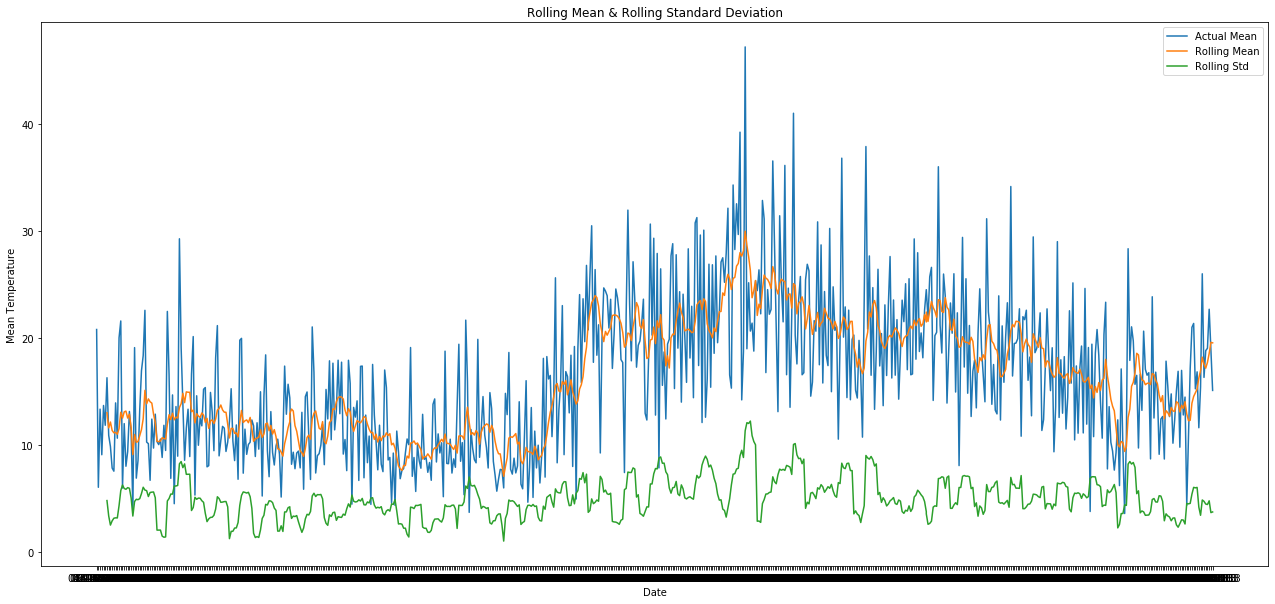

Test statistic:  -1.6011994675461299
Critical Values: {'1%': -3.4407890899441127, '5%': -2.8661459340578905, '10%': -2.5692228868342766}


In [61]:
# check stationary: mean, variance(std)and adfuller test
plot_rolling_mean_std(train.total_consumption)
perform_dickey_fuller_test(train.total_consumption)

In [62]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [63]:
# # MAPE value function
# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# # Evaluation result
# def evaluate_ts(testY,testPredict):
#     MAE = round(median_absolute_error(testY,testPredict),4)
#     MAPE = round(mean_absolute_percentage_error(testY,testPredict),4)
#     MSE = round(mean_squared_error(testY,testPredict),4)
#     RMSE = round(math.sqrt(MSE),4)
#     return MAE,MAPE,MSE,RMSE

def MLP(block,household,train_percent,look_back,epochs):
    df_test = reframe_dataset(block,household)
    df_tc = df_test['total_consumption']
    df_tc = pd.DataFrame(df_tc)
#     df_tc
    dataset = df_tc.values
#     print(dataset)
#     print(int(train_percent))
    #dataset = dataset.astype('float32')
    train_size = int(len(dataset) * train_percent)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,0], dataset[train_size:len(dataset),0]
#     print(len(train), len(test))

#     look_back = 3
    trainX, trainY = create_dataset(train, int(look_back))
    testX, testY = create_dataset(test, int(look_back))

#     print("Train:",trainX.shape, trainY.shape)
#     print("Test:",testX.shape, testY.shape)
    
    # create and fit Multilayer Perceptron model
    model = Sequential()
    model.add(Dense(12, input_dim=int(look_back), activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=int(epochs), batch_size=2, verbose=2)


    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
#     print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
#     print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    fig_map, gr = plt.subplots()
    
def reframe_dataset(block,household):
    hh_name = "hhblock_dataset/block_"+str(block)+".csv"
    df = pd.read_csv(hh_name)
    df_test = df[df['LCLid'] == str(household)]
    df_test['total_consumption'] = round(df_test.sum(axis=1),2)
    df_test['day_'] = pd.to_datetime(df_test['day'], format='%d-%m-%Y')
    df_test['year'] = pd.DatetimeIndex(df_test['day_']).year
    df_test['month'] = pd.DatetimeIndex(df_test['day_']).month
    df_test['date'] = pd.DatetimeIndex(df_test['day_']).day
    df_test = df_test[['day','total_consumption','date','month','year']]
    return df_test

# Split dataset into train and test sets
def split_to_train_test(dataset,train_percent):
    dataset = dataset.values
    train_size = int(len(dataset) * train_percent)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,0], dataset[train_size:len(dataset),0]
    print(len(train), len(test))
    return train,test

In [64]:
train_percent = 0.8
look_back = 2
dataset = df_hh[['total_consumption']]
dataset = dataset.values


train_size = int(len(dataset) * train_percent)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,0], dataset[train_size:len(dataset),0]


trainX, trainY = create_dataset(train, int(look_back))
testX, testY = create_dataset(test, int(look_back))

In [65]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(12, input_dim=int(look_back), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=400, batch_size=2, verbose=2)


# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
#     print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
#     print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict



Epoch 1/400
 - 1s - loss: 141.7268
Epoch 2/400
 - 0s - loss: 40.7670
Epoch 3/400
 - 0s - loss: 39.4009
Epoch 4/400
 - 0s - loss: 39.5864
Epoch 5/400
 - 0s - loss: 38.9253
Epoch 6/400
 - 0s - loss: 38.9583
Epoch 7/400
 - 0s - loss: 38.9182
Epoch 8/400
 - 0s - loss: 38.5781
Epoch 9/400
 - 0s - loss: 38.0781
Epoch 10/400
 - 0s - loss: 38.0670
Epoch 11/400
 - 0s - loss: 38.0359
Epoch 12/400
 - 0s - loss: 37.6751
Epoch 13/400
 - 0s - loss: 37.4449
Epoch 14/400
 - 0s - loss: 37.9099
Epoch 15/400
 - 0s - loss: 37.5983
Epoch 16/400
 - 0s - loss: 37.1721
Epoch 17/400
 - 0s - loss: 37.0629
Epoch 18/400
 - 0s - loss: 37.2098
Epoch 19/400
 - 0s - loss: 36.9209
Epoch 20/400
 - 0s - loss: 36.8560
Epoch 21/400
 - 0s - loss: 36.7051
Epoch 22/400
 - 0s - loss: 36.7755
Epoch 23/400
 - 0s - loss: 36.5369
Epoch 24/400
 - 0s - loss: 36.5532
Epoch 25/400
 - 0s - loss: 36.6214
Epoch 26/400
 - 0s - loss: 36.4440
Epoch 27/400
 - 0s - loss: 36.4122
Epoch 28/400
 - 0s - loss: 36.4257
Epoch 29/400
 - 0s - loss: 

 - 0s - loss: 35.9908
Epoch 226/400
 - 0s - loss: 35.7049
Epoch 227/400
 - 0s - loss: 35.8940
Epoch 228/400
 - 0s - loss: 35.9404
Epoch 229/400
 - 0s - loss: 35.6868
Epoch 230/400
 - 0s - loss: 35.9403
Epoch 231/400
 - 0s - loss: 35.7052
Epoch 232/400
 - 0s - loss: 35.6785
Epoch 233/400
 - 0s - loss: 35.8316
Epoch 234/400
 - 0s - loss: 35.6112
Epoch 235/400
 - 0s - loss: 35.8252
Epoch 236/400
 - 0s - loss: 35.8883
Epoch 237/400
 - 0s - loss: 35.9042
Epoch 238/400
 - 0s - loss: 35.8697
Epoch 239/400
 - 0s - loss: 35.6420
Epoch 240/400
 - 0s - loss: 35.7945
Epoch 241/400
 - 0s - loss: 35.5502
Epoch 242/400
 - 0s - loss: 35.7566
Epoch 243/400
 - 0s - loss: 35.5050
Epoch 244/400
 - 0s - loss: 36.2482
Epoch 245/400
 - 0s - loss: 35.8809
Epoch 246/400
 - 0s - loss: 36.0526
Epoch 247/400
 - 0s - loss: 35.6494
Epoch 248/400
 - 0s - loss: 35.8103
Epoch 249/400
 - 0s - loss: 36.0331
Epoch 250/400
 - 0s - loss: 35.6822
Epoch 251/400
 - 0s - loss: 35.9870
Epoch 252/400
 - 0s - loss: 35.4767
Epoch 

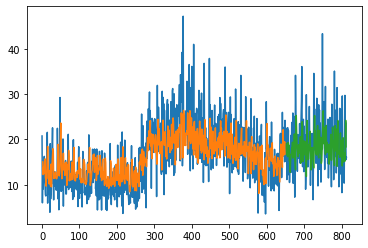

In [66]:
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [67]:
MAE,MAPE,MSE,RMSE = evaluate_ts(testY,testPredict)
print('MAE:', MAE,'MAPE:', MAPE,'MSE:',MSE,'RMSE:',RMSE)

MAE: 3.977266464233397 MAPE: 29.584186762907112 MSE: 45.65762821615784 RMSE: 6.75704286031677
